In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import functools
import pvtrace
import scintillator_tracer as st

In [4]:
PLATE_STL = '/home/reed/Documents/research/grimpress/crystal-geometry/notebooks/isosceles_prisms/cut_progression/models/plate-Body.stl'
PLATE_ESR_SHELL_STL = '/home/reed/Documents/research/grimpress/crystal-geometry/notebooks/isosceles_prisms/cut_progression/models/plate-esr-shell-Body.stl'

In [12]:
def build_plate_world(
    crystal_kwargs: dict = {},
    esr_shell_kwargs: dict = {},
    optical_pad_kwargs: dict = {},
    sipm_kwargs: dict = {},
    world: pvtrace.Node = None
) -> dict:
    """
    The kwargs for each node are the arguments to their respective generation
    functions in the "definitions" submodule. If not specified, the defaults
    will be used.
    """
    
    if world is None:
        world = st.definitions.generate_world()
    
    DEFAULT_KWARGS = dict(
        crystal = dict(
            stl_file=PLATE_STL,
            scaling=0.1,
            world=world
        ),
        esr_shell = dict(
            stl_file=PLATE_ESR_SHELL_STL,
            scaling=0.1,
            world=world
        ),
        optical_pad = dict(
            world=world,
            size=(0.4, 6.6, 0.01)
        ),
        sipm = dict(
            world=world,
            size=(0.6, 6.6, 0.05)
        )
    )
    
    crystal = st.definitions.generate_crystal(**{**DEFAULT_KWARGS['crystal'], **crystal_kwargs})
    esr_shell = st.definitions.generate_esr_shell(**{**DEFAULT_KWARGS['esr_shell'], **esr_shell_kwargs})
    optical_pad = st.definitions.generate_optical_pad(**{**DEFAULT_KWARGS['optical_pad'], **optical_pad_kwargs})
    sipm = st.definitions.generate_sipm(**{**DEFAULT_KWARGS['sipm'], **sipm_kwargs})

    st.worlds.basic_stack(crystal, esr_shell, optical_pad, sipm, 0.0101)

    nodes = dict(
        world=world,
        crystal=crystal,
        esr_shell=esr_shell,
        optical_pad=optical_pad,
        sipm=sipm
    )

    return nodes

# Verification

In [13]:
world_func = functools.partial(build_plate_world)
nodes = world_func()
world = nodes['world']

height = st.geometry_helpers.get_node_height(nodes['crystal'])
light = st.definitions.generate_scintillated_light_node(world)
light.location = (0, 0, height/2)

scene = pvtrace.Scene(world)
all_ray_steps = st.processing.process_photons_with_visual(scene, 100, seed=100, open_browser=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


# Grid trials

In [14]:
nodes = world_func()
crystal = nodes['crystal']

zrange = (
    st.geometry_helpers.min_physical_value(crystal, 'z')+0.4,
    st.geometry_helpers.max_physical_value(crystal, 'z')-0.3,
)
yrange = (
    st.geometry_helpers.min_physical_value(crystal, 'y')+0.5,
    st.geometry_helpers.max_physical_value(crystal, 'y')-0.5,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


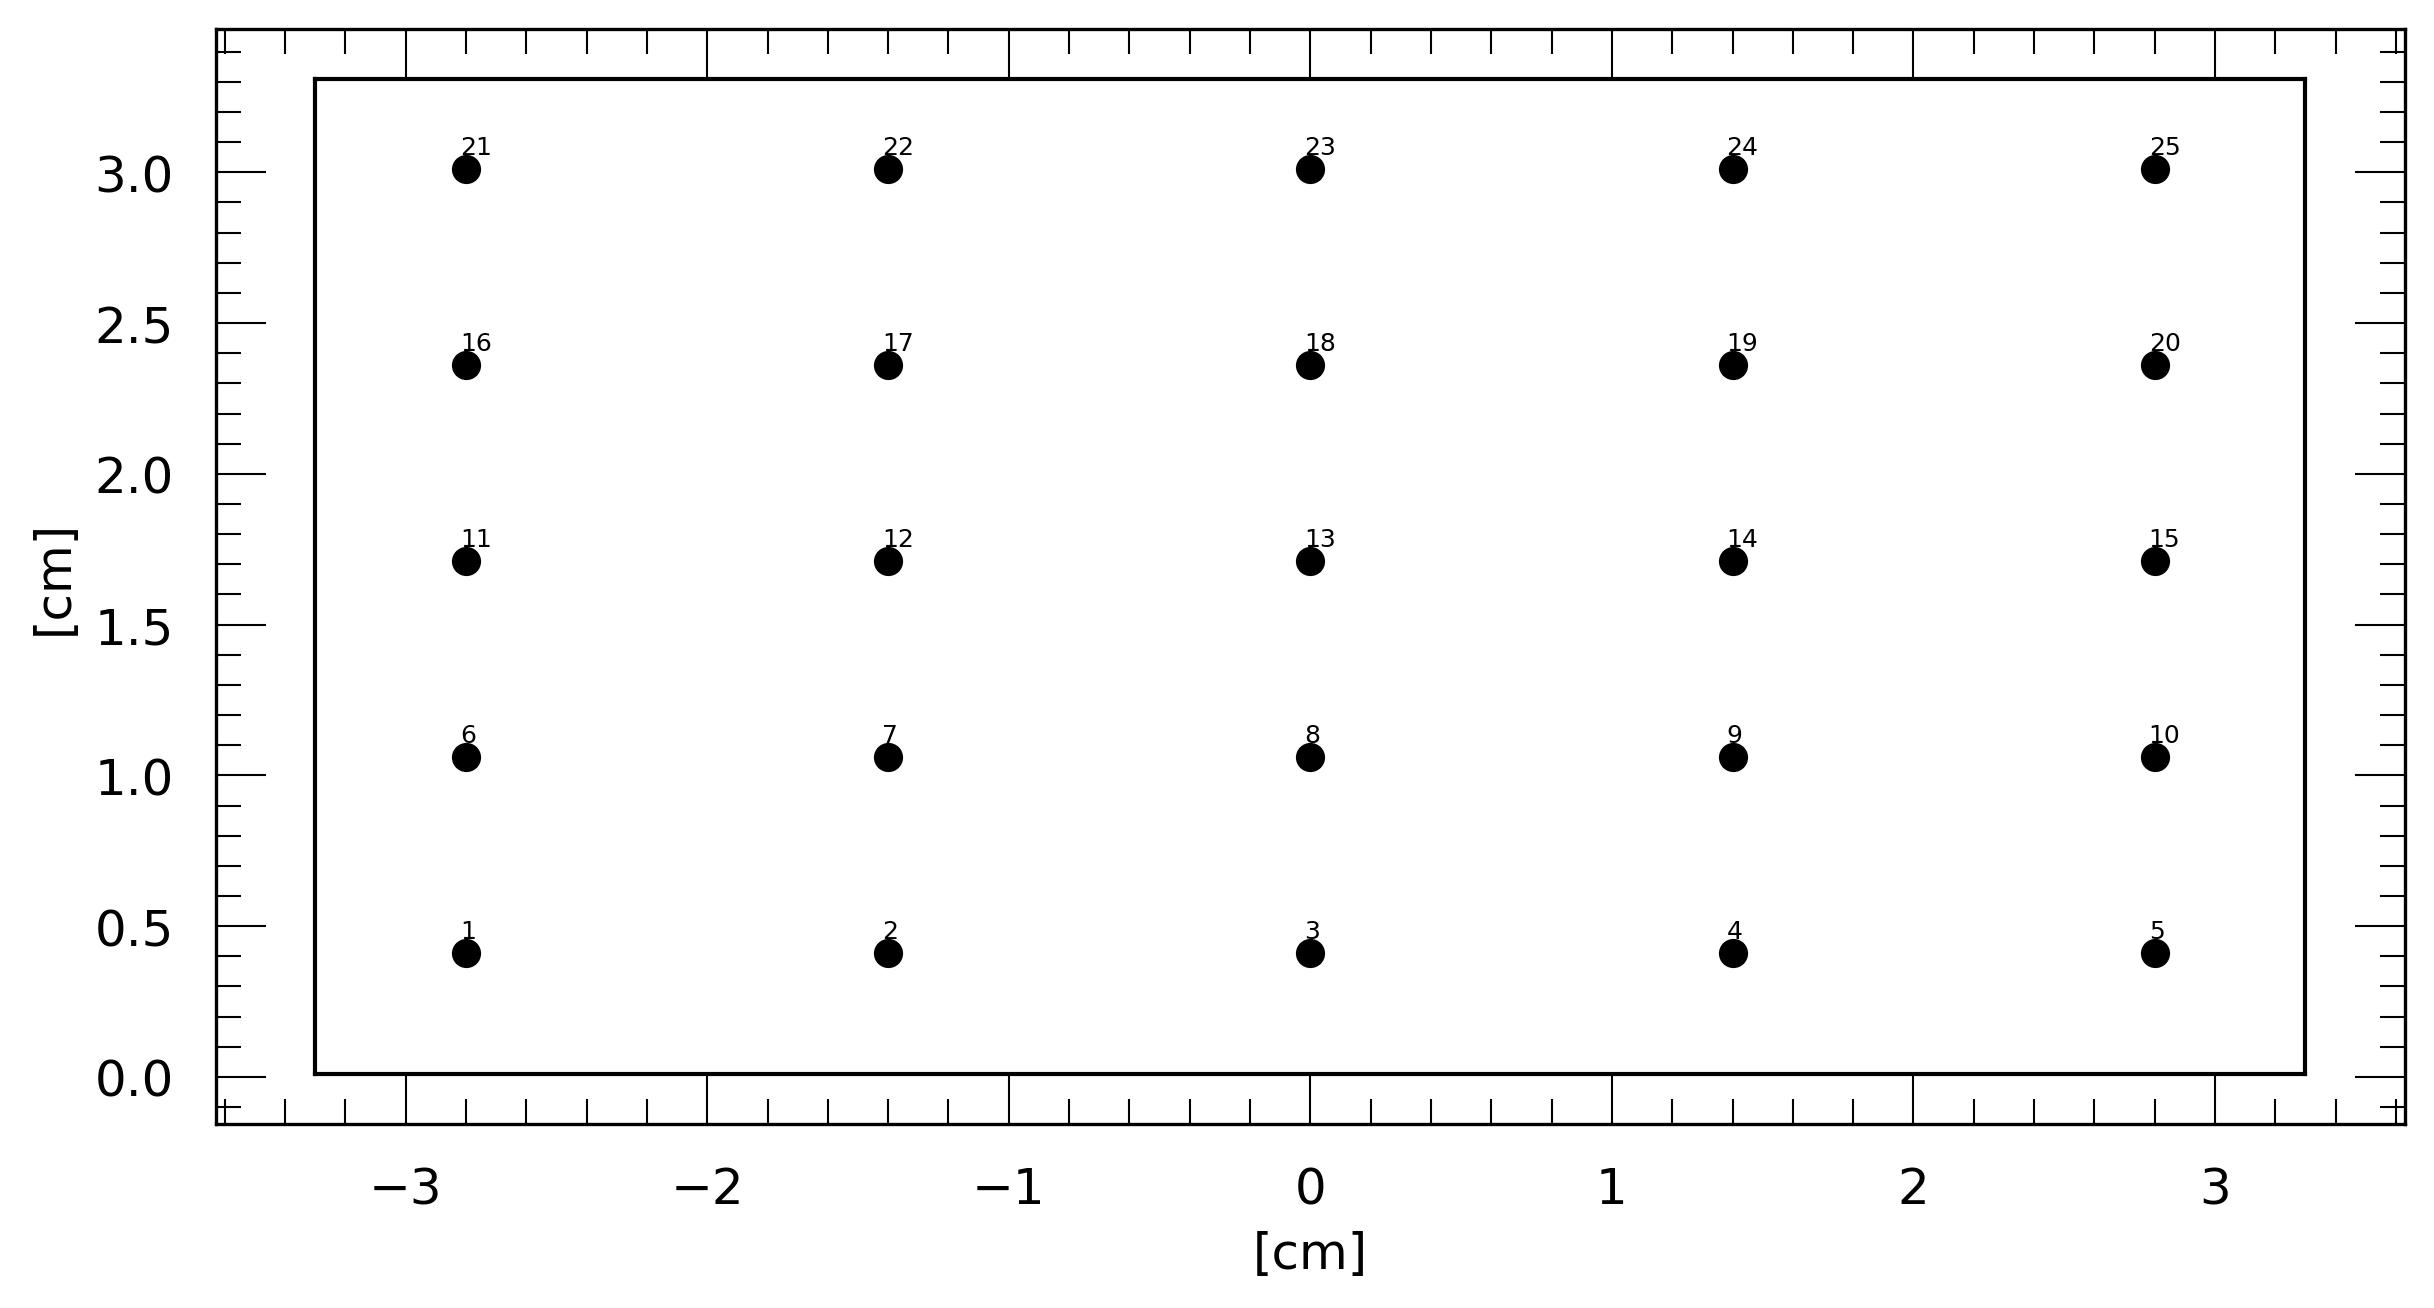

In [15]:
steps = 5
man = st.processing.Manager(world_func, out_dir=f'plate/')
man.define_grid(
    vertical_range=zrange,
    horizontal_func=lambda z: yrange,
    steps=steps,
    visualize=True
)

## Run

In [16]:
runs = man.run(200, seed=100, visualize=False)

plate/runs_20240808T131621/figures/crystal_absorbed.png
plate/runs_20240808T131621/figures/optical pad_absorbed.png
plate/runs_20240808T131621/figures/sipm_absorbed.png


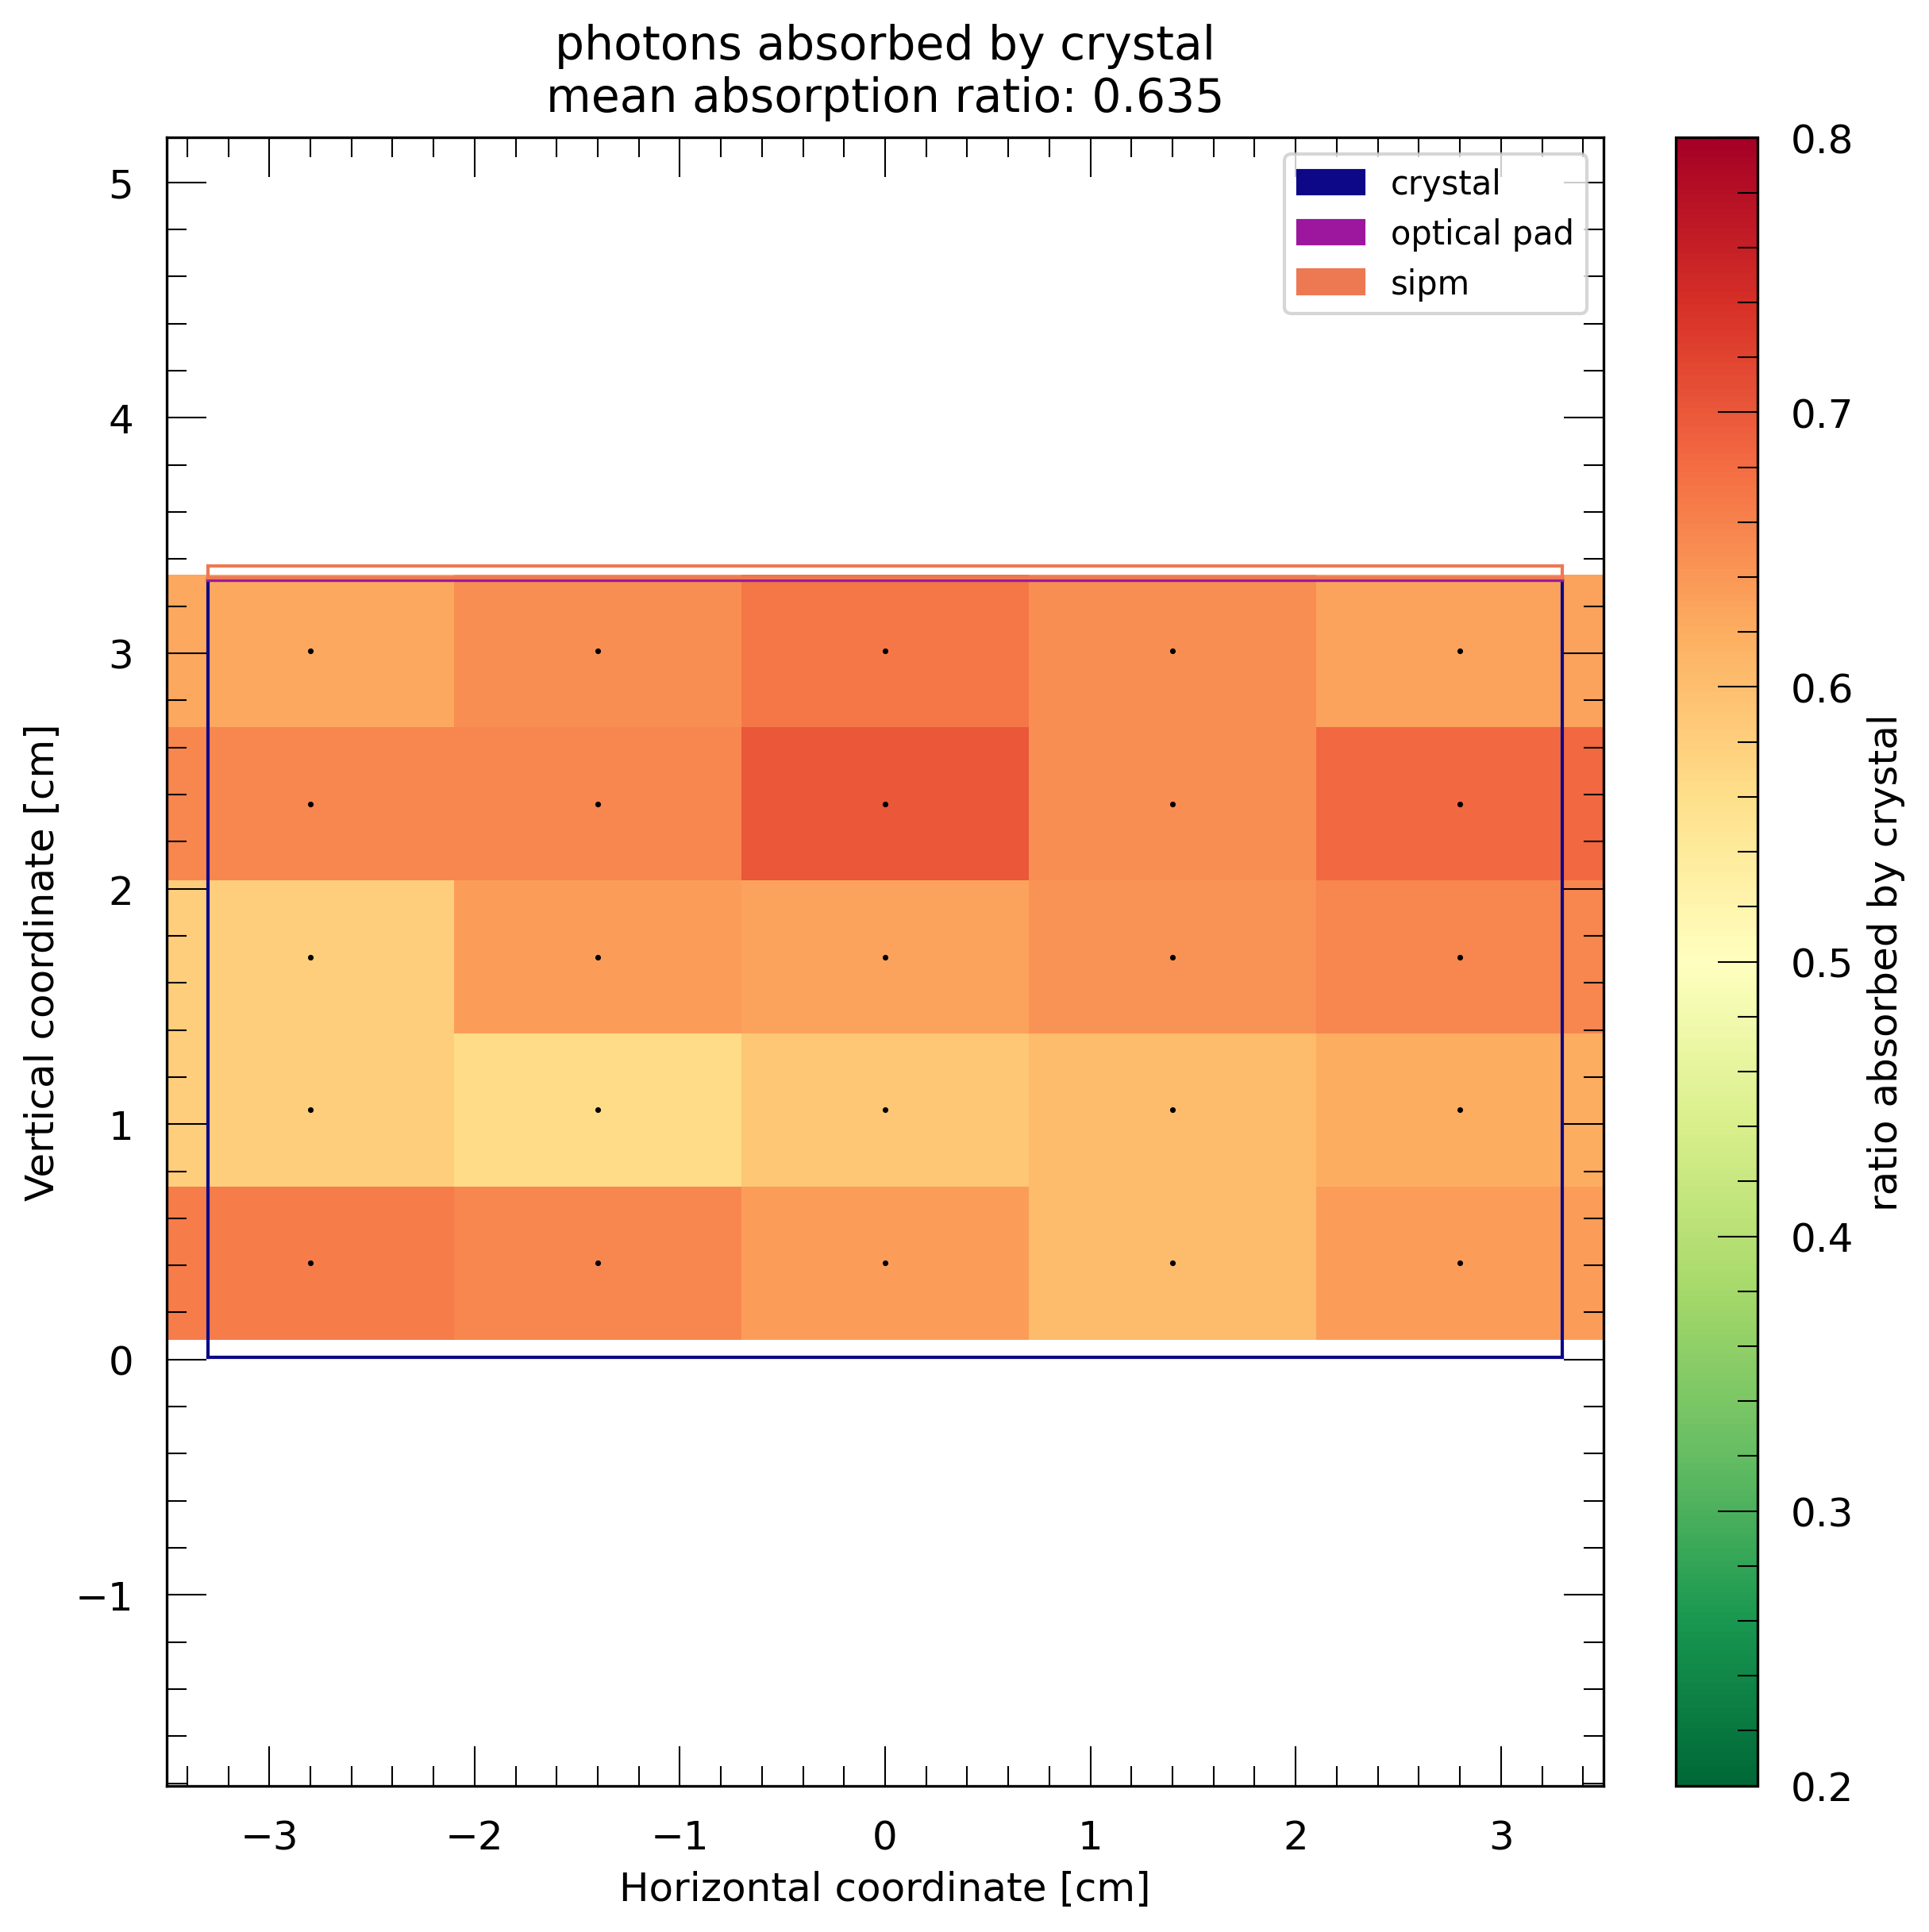

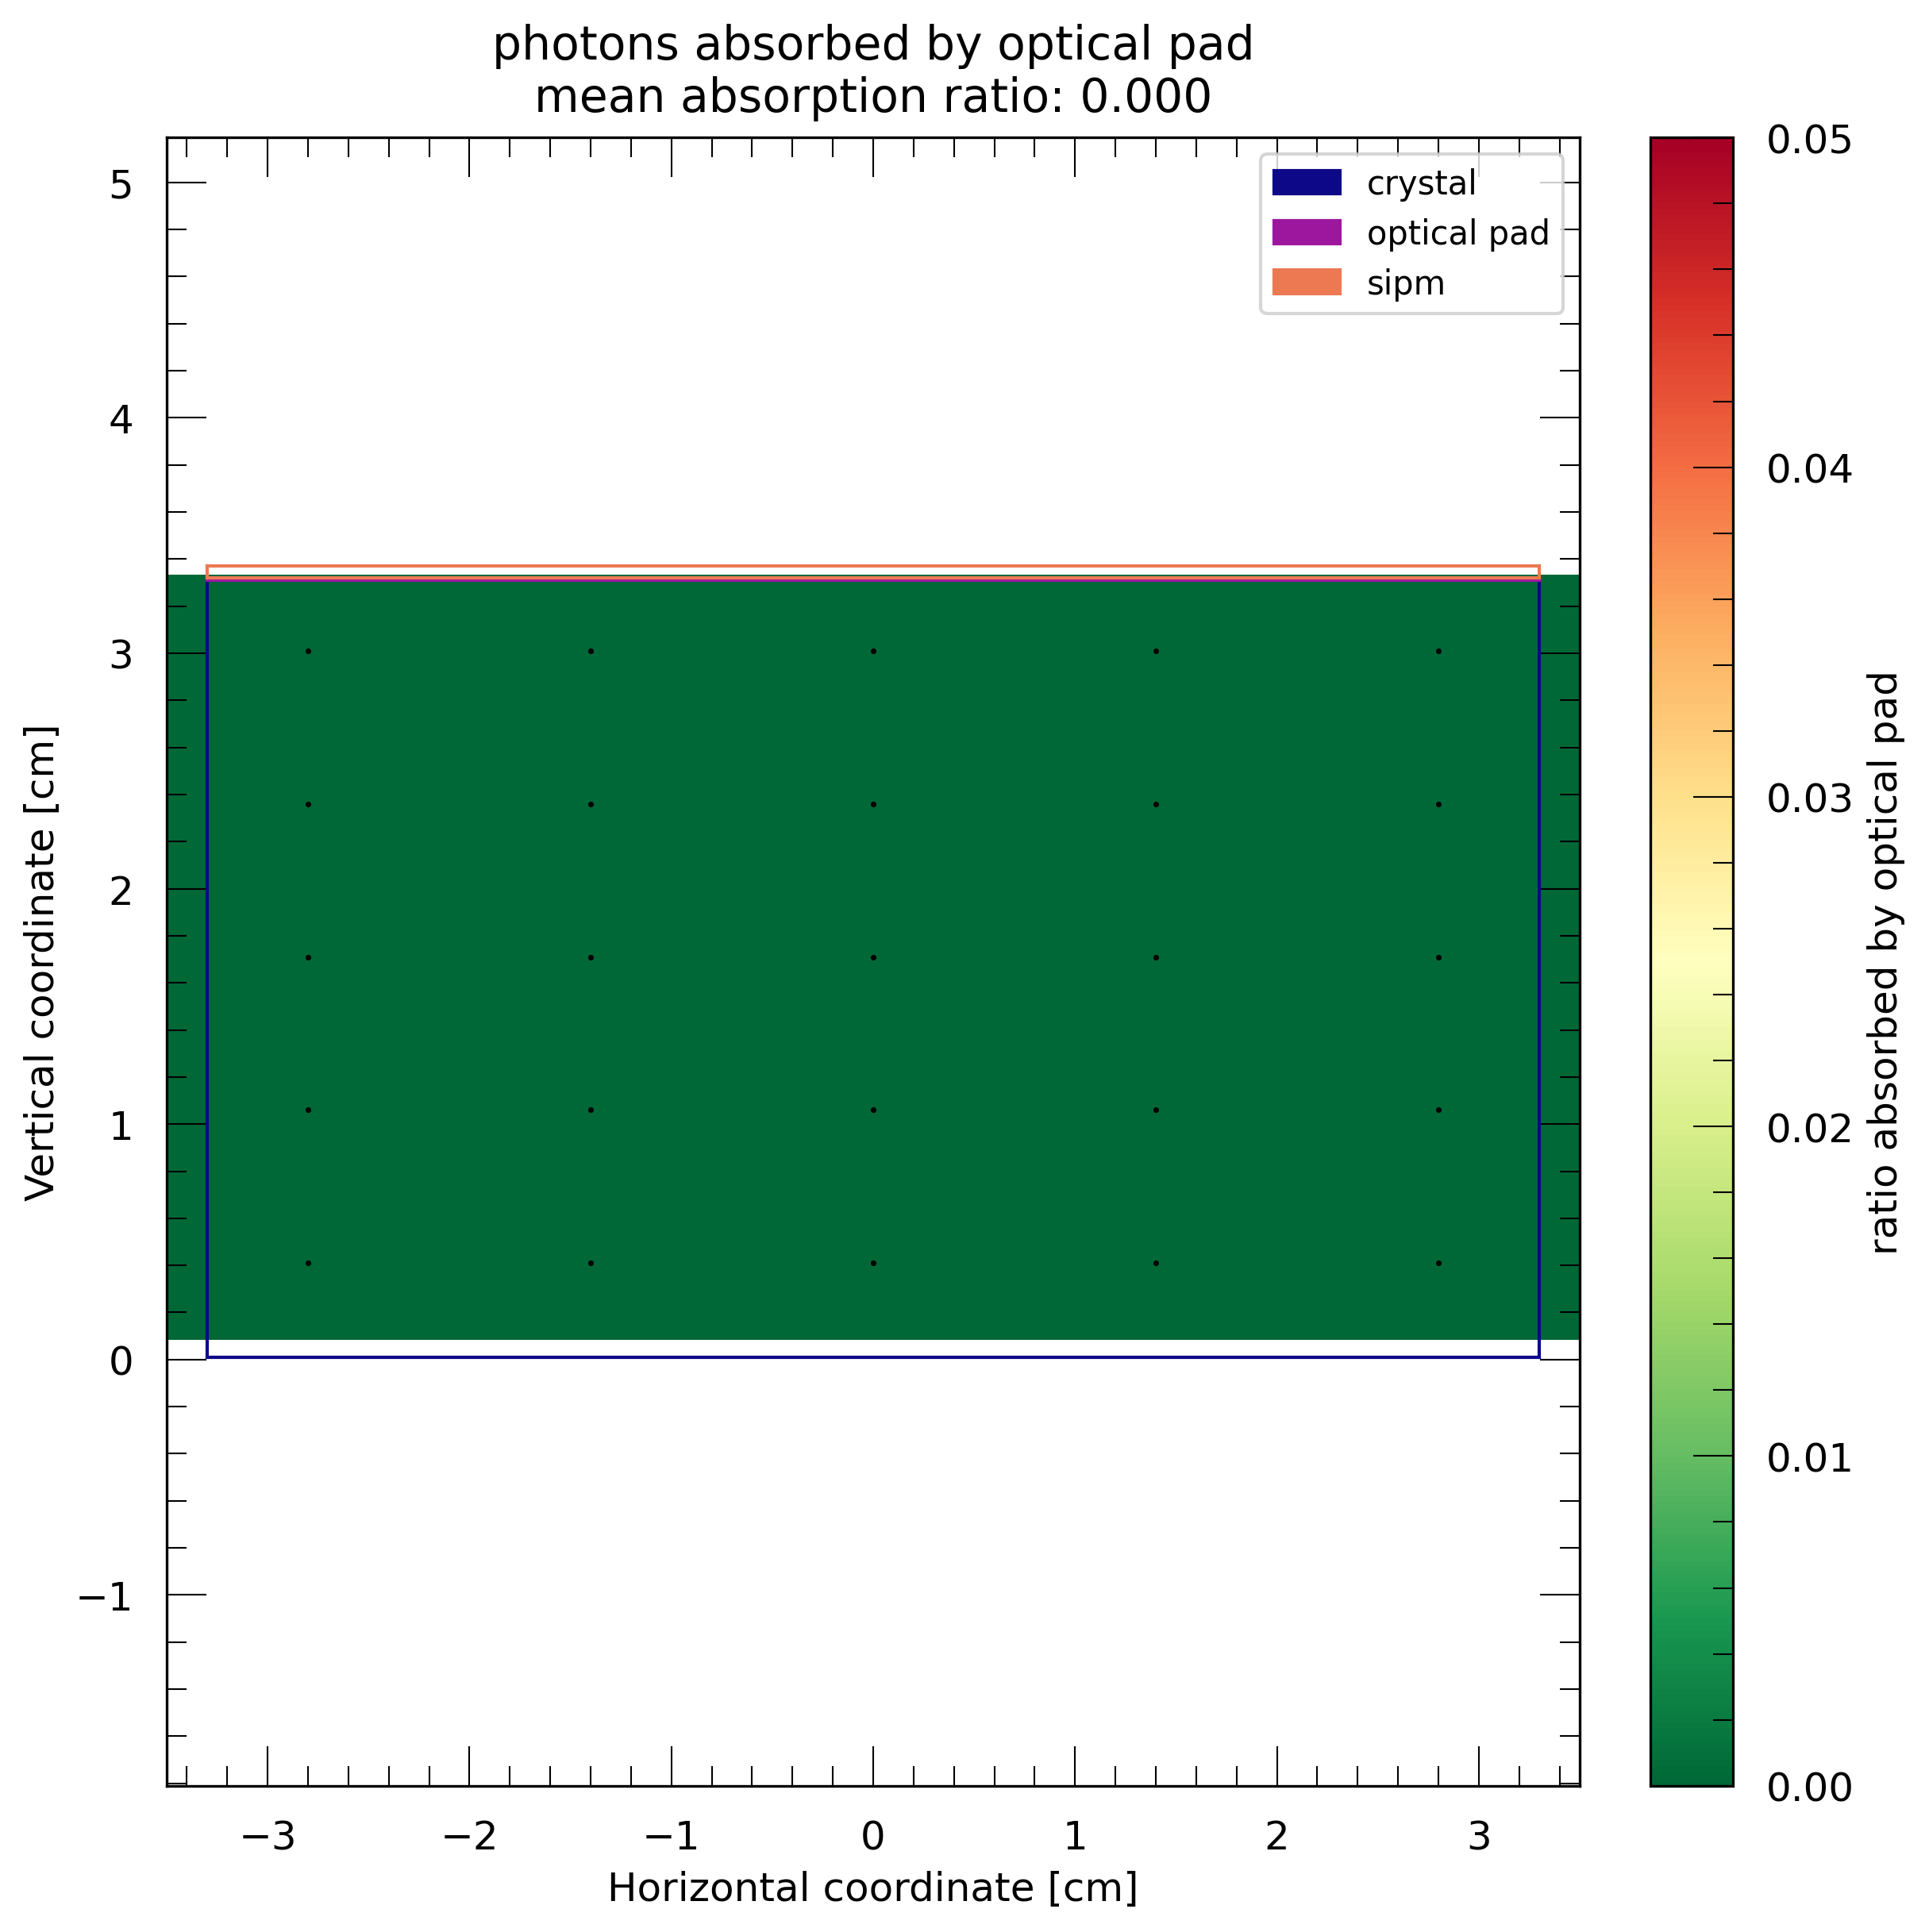

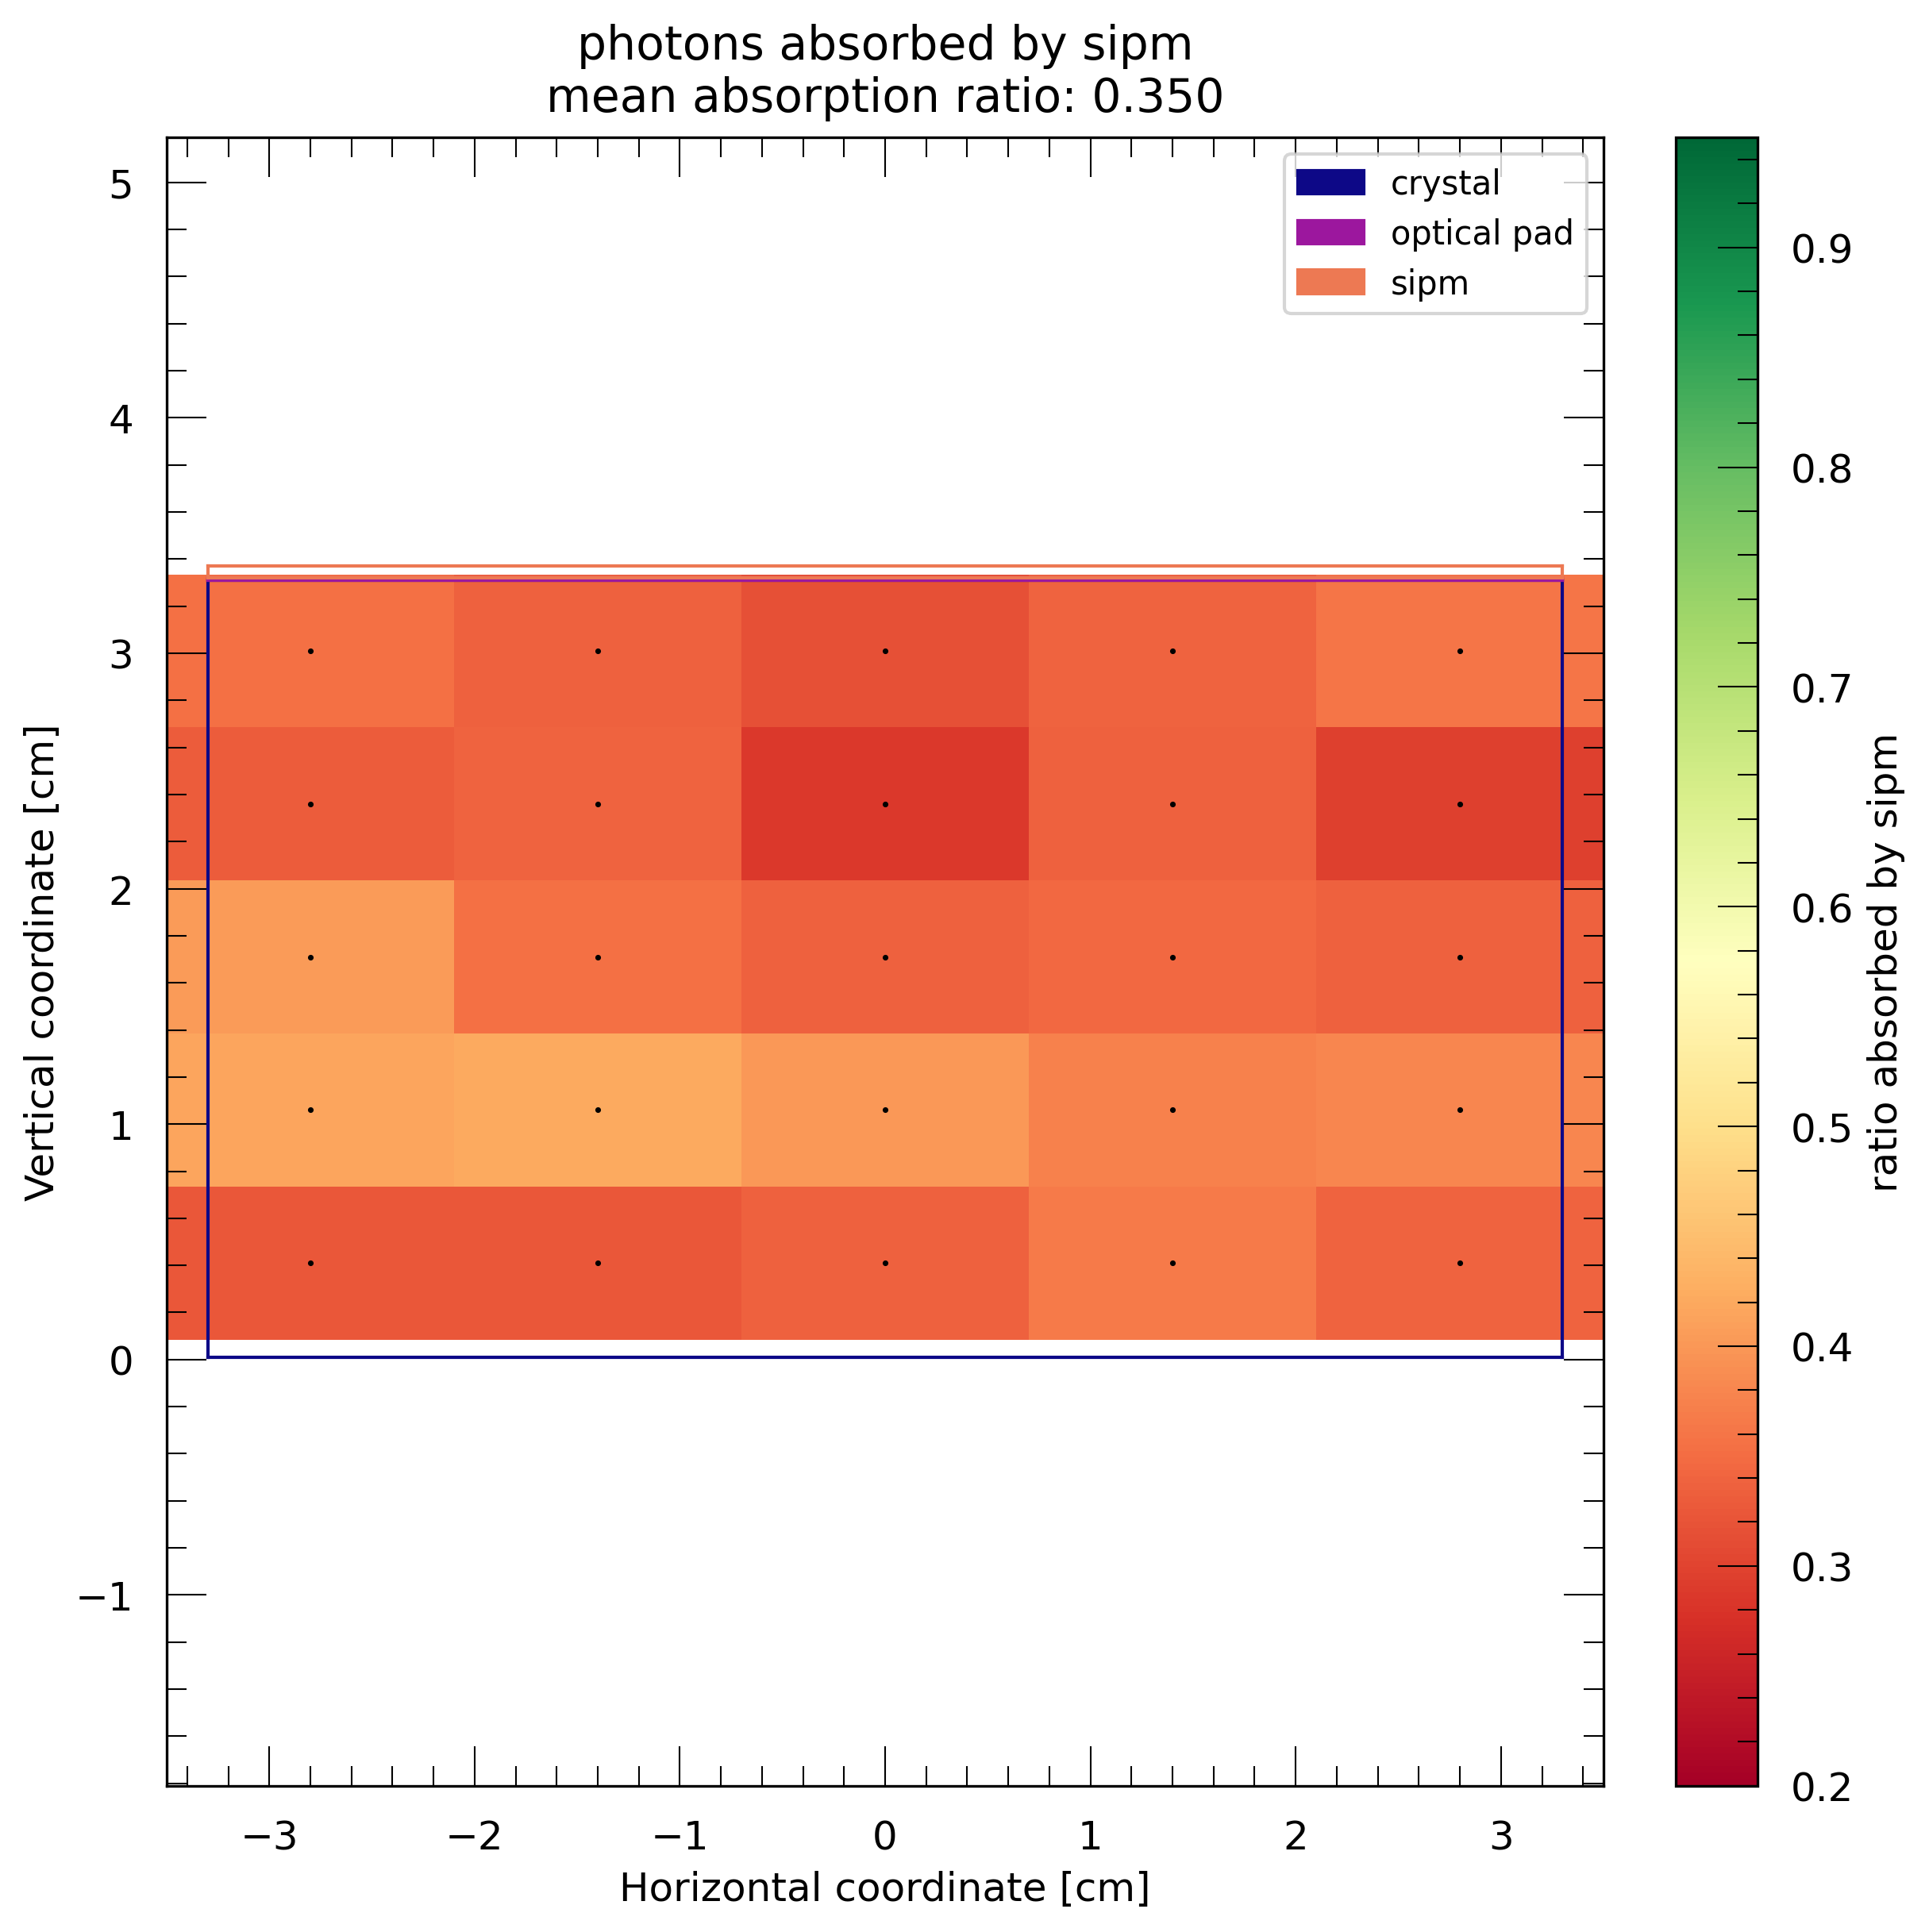

In [17]:
man.plot_all_ratios_absorbed(sipm_kwargs=dict(vmax=0.95))